Objective:
Develop a Zero-Shot Learning (ZSL) model to classify spam messages in Vehicle-to-Everything (V2X) communication using the provided dataset (V2X_train - Sheet1.csv). 
The model should be able to generalize to unseen classes of spam messages that were not present during training.

Dataset:
V2X_Data.csv: Contains V2X communication messages with features like Source Vehicle, Destination Vehicle, Message Type, Message Content, Priority, and a label indicating whether the message is Spam (Yes/No).

In [16]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from transformers import RobertaTokenizer, RobertaModel
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from textblob import TextBlob

In [17]:
import pandas as pd  # Import the pandas library for data manipulation

# Step 1: Load the dataset
df = pd.read_csv('V2X_Data.csv')  # Read the CSV file into a DataFrame

This code section is responsible for loading the V2X communication dataset from a CSV file into a pandas DataFrame. 
This DataFrame will be used for further data processing and analysis.

In [18]:
import pandas as pd  # Ensure pandas is imported for data manipulation
from sklearn.preprocessing import OneHotEncoder  # Import OneHotEncoder for encoding categorical features

# Step 2: Data Preparation
# Convert categorical features into numerical representations

# List of categorical columns to be encoded
categorical_columns = ['Source Vehicle', 'Destination Vehicle', 'Message Type', 'Priority']

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)  # `sparse_output=False` ensures the output is a dense array

# Fit and transform the categorical columns
encoded_features = encoder.fit_transform(df[categorical_columns])

# Convert the encoded features into a DataFrame
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_columns))


This section is responsible for converting categorical features in the dataset into numerical representations using one-hot encoding. 
This transformation is necessary for machine learning models, which typically require numerical input.

Dependencies:
OneHotEncoder from sklearn.preprocessing: For converting categorical features into numerical format.

Explanation:
categorical_columns: 
A list of column names in the DataFrame that contain categorical data and need to be encoded.

OneHotEncoder(sparse_output=False): 
Initializes the OneHotEncoder with sparse_output=False to return a dense array instead of a sparse matrix. 
This can be more convenient for working with small to medium-sized datasets.

encoder.fit_transform(df[categorical_columns]): 
Applies the one-hot encoding to the specified categorical columns in the DataFrame df. 
This method returns a dense array of encoded features.

encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_columns)): 
Converts the array of encoded features into a new DataFrame encoded_df with appropriate column names.

In [19]:
# Convert the Spam label into numerical values

# Convert 'Spam' column to binary numerical values: 1 for 'Yes' and 0 for 'No'
df['Spam'] = df['Spam'].apply(lambda x: 1 if x == 'Yes' else 0)


This section of the code is responsible for converting the categorical 'Spam' label into numerical values. 
This is a common preprocessing step in machine learning to convert categorical labels into a format suitable for model training.

Explanation:
df['Spam']: Refers to the 'Spam' column in the DataFrame df.

.apply(lambda x: 1 if x == 'Yes' else 0): Uses the apply method with a lambda function to transform each value in the 'Spam' column. 
The lambda function checks if the value is 'Yes', in which case it converts it to 1. 
Otherwise, it converts it to 0.

In [20]:
import pandas as pd  # Ensure pandas is imported for data manipulation
from textblob import TextBlob  # Import TextBlob for sentiment analysis

# Feature Engineering

# Add a new feature: Message Length
df['Message Length'] = df['Message Content'].apply(len)  
# Computes the length of each message and stores it in a new column 'Message Length'

# Add a new feature: Sentiment
df['Sentiment'] = df['Message Content'].apply(lambda x: TextBlob(x).sentiment.polarity)
# Uses TextBlob to compute the sentiment polarity of each message and stores it in a new column 'Sentiment'


This section enhances the dataset by creating new features that could potentially improve model performance. 
Specifically, it adds features for message length and sentiment.

Dependencies:
TextBlob: For performing sentiment analysis on text data.Explanation:
df['Message Length'] = df['Message Content'].apply(len): Adds a new column named 'Message Length' to the DataFrame df, which contains the length of each message. The apply(len) function computes the length of each message in the 'Message Content' column.

df['Sentiment'] = df['Message Content'].apply(lambda x: TextBlob(x).sentiment.polarity): 
Adds a new column named 'Sentiment' to the DataFrame df, which contains the sentiment polarity of each message. 
The TextBlob(x).sentiment.polarity computes the sentiment score, where the polarity score ranges from -1 (very negative) to +1 (very positive).

In [21]:
import pandas as pd  # Ensure pandas is imported for data manipulation
import torch  # Import PyTorch for tensor operations
from transformers import RobertaTokenizer, RobertaModel  # Import RoBERTa tokenizer and model

# Initialize RoBERTa tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')  # Load the RoBERTa tokenizer
model = RobertaModel.from_pretrained('roberta-base')  # Load the RoBERTa model

# Function to get RoBERTa embeddings
def get_roberta_embedding(text):
    # Tokenize the input text and convert it into PyTorch tensors
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    
    # Forward pass through the RoBERTa model to get the embeddings
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Average the token embeddings to get a single vector representation for the text
    embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
    return embeddings

# Generate embeddings using RoBERTa
df['Message Content Embedding'] = df['Message Content'].apply(get_roberta_embedding)
# Apply the embedding function to each message content and store the resulting embeddings in a new column

# Convert the embeddings from a list of arrays into a DataFrame
embeddings_df = pd.DataFrame(df['Message Content Embedding'].tolist(), index=df.index)


c:\Users\Hasibul Hamim\anaconda3\envs\RA_jpn\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


This section of the code is used to generate embeddings for the 'Message Content' using the RoBERTa model. 
Embeddings are numerical representations of text that capture semantic meaning and are used as input features for machine learning models.

Dependencies:
torch: For tensor operations and handling PyTorch models.
transformers: For using pre-trained models like RoBERTa from the Hugging Face library.

Explanation:
RobertaTokenizer.from_pretrained('roberta-base'): 
Loads the pre-trained RoBERTa tokenizer, which converts text into token IDs that the RoBERTa model can understand.

RobertaModel.from_pretrained('roberta-base'): 
Loads the pre-trained RoBERTa model, which generates embeddings for the input text.

get_roberta_embedding(text): 
Defines a function to obtain RoBERTa embeddings for a given text. The function:
Tokenizes the input text using the tokenizer.
Passes the tokenized input through the RoBERTa model to get the embeddings.
Averages the token embeddings to create a single vector for the entire text.
Converts the tensor to a NumPy array.

df['Message Content Embedding'] = df['Message Content'].apply(get_roberta_embedding): 
Applies the get_roberta_embedding function to each message in the 'Message Content' column and stores the embeddings in a new column 'Message Content Embedding'.

embeddings_df = pd.DataFrame(df['Message Content Embedding'].tolist(), index=df.index): 
Converts the list of embedding arrays into a DataFrame, where each row corresponds to the embeddings of a message.

In [22]:
import pandas as pd  # Ensure pandas is imported for data manipulation

# Merge embeddings with the main dataframe

# Drop original categorical columns and non-numeric columns ('Message Content', 'Message Content Embedding')
# Concatenate encoded categorical features to the remaining DataFrame
df_encoded = pd.concat([df.drop(columns=categorical_columns + ['Message Content', 'Message Content Embedding']), encoded_df], axis=1)

# Concatenate the embeddings DataFrame with the previously prepared DataFrame
df_encoded = pd.concat([df_encoded, embeddings_df], axis=1)

# Convert all column names to strings to ensure consistency
df_encoded.columns = df_encoded.columns.astype(str)


Step 3: Identify Seen and Unseen Classes

In [23]:
# Step 3: Identify Seen and Unseen Classes
# seen_classes = df[df['Spam'] == 1]['Message Type'].unique()
# unseen_classes = df[~df['Message Type'].isin(seen_classes)]['Message Type'].unique()

# Filter for seen classes
seen_classes_df = df[df['Message Type'].isin(['Emergency', 'Spam'])]
# Extract unique seen classes
seen_classes = seen_classes_df['Message Type'].unique()
unseen_classes = df[~df['Message Type'].isin(seen_classes)]['Message Type'].unique()
# Print the identified seen classes
print("Seen Classes:", ', '.join(seen_classes))
# Print the identified seen classes
print("unSeen Classes:", ', '.join(unseen_classes))


df_seen = df[df['Message Type'].isin(seen_classes)]
df_unseen = df[df['Message Type'].isin(unseen_classes)]

# Print the identified seen and unseen classes
print("Seen Classes:", seen_classes)
print("Unseen Classes:", unseen_classes)

Seen Classes: Emergency, Spam
unSeen Classes: Roadwork, Weather, Traffic, Hazard
Seen Classes: ['Emergency' 'Spam']
Unseen Classes: ['Roadwork' 'Weather' 'Traffic' 'Hazard']


This section combines the preprocessed features and embeddings into a single DataFrame suitable for machine learning tasks.It consolidates categorical encodings, additional features, and text embeddings.

Explanation:
df.drop(columns=categorical_columns + ['Message Content', 'Message Content Embedding']):
Drops the original categorical columns and the 'Message Content' column from the DataFrame df. It also drops the 'Message Content Embedding' column to avoid redundancy.

pd.concat([..., encoded_df], axis=1): 
Concatenates the DataFrame with the encoded categorical features (encoded_df) along the columns (axis=1).

pd.concat([df_encoded, embeddings_df], axis=1): 
Appends the DataFrame containing the RoBERTa embeddings (embeddings_df) to the previously prepared DataFrame (df_encoded).

df_encoded.columns = df_encoded.columns.astype(str): 
Converts all column names to strings to ensure consistency and avoid potential issues with column name types during further processing.

In [24]:
import pandas as pd  # Ensure pandas is imported for data manipulation
from sklearn.model_selection import train_test_split  # Import train_test_split for splitting data

# Step 4: Split the Data into Training and Testing Sets

# Split the data into training and testing sets
# test_size=0.2 specifies that 20% of the data should be used for testing
# stratify=df['Spam'] ensures the proportion of spam and non-spam messages is maintained in both sets
# random_state=42 ensures that the split is reproducible
X_train, X_test, y_train, y_test = train_test_split(df_encoded, df['Spam'], test_size=0.2, stratify=df['Spam'], random_state=42)

# Extract training and testing data for seen and unseen classes

# Combine the training features with their corresponding rows from the original DataFrame
df_train = pd.concat([df.iloc[X_train.index], pd.DataFrame(X_train)], axis=1)

# Combine the testing features with their corresponding rows from the original DataFrame
df_test = pd.concat([df.iloc[X_test.index], pd.DataFrame(X_test)], axis=1)

# Filter training data to include only seen classes
X_train_seen = X_train[df_train['Message Type'].isin(seen_classes)]
y_train_seen = y_train[df_train['Message Type'].isin(seen_classes)]

# Filter testing data to include only seen classes
X_test_seen = X_test[df_test['Message Type'].isin(seen_classes)]
y_test_seen = y_test[df_test['Message Type'].isin(seen_classes)]

# Filter testing data to include only unseen classes
X_test_unseen = X_test[df_test['Message Type'].isin(unseen_classes)]
y_test_unseen = y_test[df_test['Message Type'].isin(unseen_classes)]

# Ensure labels are numeric (convert from any potential non-numeric types)
y_train_seen = y_train_seen.astype(int)
y_test_seen = y_test_seen.astype(int)
y_test_unseen = y_test_unseen.astype(int)

# Print the shape of the testing sets for seen and unseen classes
print(f"X_test_seen shape: {X_test_seen.shape}")
print(f"X_test_unseen shape: {X_test_unseen.shape}")


X_test_seen shape: (82, 834)
X_test_unseen shape: (106, 834)


In [25]:
import torch  # Ensure PyTorch is imported for tensor operations

# Convert data to PyTorch tensors

# Convert training features for seen classes to PyTorch tensors with float32 data type
X_train_tensor = torch.tensor(X_train_seen.values, dtype=torch.float32)

# Convert training labels for seen classes to PyTorch tensors with long data type (for classification labels)
y_train_tensor = torch.tensor(y_train_seen.values, dtype=torch.long)

# Convert testing features for seen classes to PyTorch tensors with float32 data type
X_test_tensor = torch.tensor(X_test_seen.values, dtype=torch.float32)

# Convert testing labels for seen classes to PyTorch tensors with long data type (for classification labels)
y_test_tensor = torch.tensor(y_test_seen.values, dtype=torch.long)

# Convert testing features for unseen classes to PyTorch tensors with float32 data type
X_test_unseen_tensor = torch.tensor(X_test_unseen.values, dtype=torch.float32)

# Convert testing labels for unseen classes to PyTorch tensors with long data type (for classification labels)
y_test_unseen_tensor = torch.tensor(y_test_unseen.values, dtype=torch.long)


torch.tensor(X_train_seen.values, dtype=torch.float32): 
Converts the training feature values for seen classes into a PyTorch tensor with a float32 data type. This is required for numerical stability and compatibility with many PyTorch operations.

torch.tensor(y_train_seen.values, dtype=torch.long): 
Converts the training labels for seen classes into a PyTorch tensor with a long data type. The long type is typically used for class labels in classification tasks.

torch.tensor(X_test_seen.values, dtype=torch.float32): 
Converts the testing feature values for seen classes into a PyTorch tensor.

torch.tensor(y_test_seen.values, dtype=torch.long): 
Converts the testing labels for seen classes into a PyTorch tensor.
torch.tensor(X_test_unseen.values, dtype=torch.float32): 
Converts the testing feature values for unseen classes into a PyTorch tensor.

torch.tensor(y_test_unseen.values, dtype=torch.long): 
Converts the testing labels for unseen classes into a PyTorch tensor.

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Define the neural network
class ZSLNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ZSLNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)  # First fully connected layer
        self.fc2 = nn.Linear(hidden_dim, output_dim)  # Second fully connected layer
        self.relu = nn.ReLU()  # ReLU activation function
        self.softmax = nn.Softmax(dim=1)  # Softmax for output layer

    def forward(self, x):
        x = self.relu(self.fc1(x))  # Apply ReLU after first layer
        x = self.fc2(x)  # Second layer
        return self.softmax(x)  # Apply softmax to get probabilities

# Initialize and train the model
input_dim = X_train_tensor.shape[1]  # Number of input features
hidden_dim = 64  # Neurons in hidden layer
output_dim = len(np.unique(y_train_seen))  # Number of output classes

model = ZSLNetwork(input_dim, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss()  # Loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)  # DataLoader

# Training loop
for epoch in range(10):  # 10 epochs
    for inputs, labels in train_loader:
        optimizer.zero_grad()  # Zero the gradients
        loss = criterion(model(inputs), labels)  # Compute loss
        loss.backward()  # Backpropagate
        optimizer.step()  # Update parameters
    #print(f'Epoch {epoch+1}/10, Loss: {loss.item():.4f}')  # Print loss


Training with hidden_dim=64 and learning_rate=0.001
Accuracy with hidden_dim=64 and learning_rate=0.001: 1.0000
Training with hidden_dim=64 and learning_rate=0.01
Accuracy with hidden_dim=64 and learning_rate=0.01: 0.5082
Training with hidden_dim=64 and learning_rate=0.1
Accuracy with hidden_dim=64 and learning_rate=0.1: 0.4918
Training with hidden_dim=128 and learning_rate=0.001
Accuracy with hidden_dim=128 and learning_rate=0.001: 1.0000
Training with hidden_dim=128 and learning_rate=0.01
Accuracy with hidden_dim=128 and learning_rate=0.01: 0.5410
Training with hidden_dim=128 and learning_rate=0.1
Accuracy with hidden_dim=128 and learning_rate=0.1: 0.4918
Training with hidden_dim=256 and learning_rate=0.001
Accuracy with hidden_dim=256 and learning_rate=0.001: 0.5246
Training with hidden_dim=256 and learning_rate=0.01
Accuracy with hidden_dim=256 and learning_rate=0.01: 0.4918
Training with hidden_dim=256 and learning_rate=0.1
Accuracy with hidden_dim=256 and learning_rate=0.1: 0.4918
Best Accuracy: 1.0000
Best Hyperparameters: {'hidden_dim': 64, 'learning_rate': 0.001}

Seen Class - Accuracy: 1.0000
Seen Class - Precision: 1.0000
Seen Class - Recall: 1.0000
Seen Class - F1-Score: 1.0000

Classification Report for Seen Classes:
              precision    recall  f1-score   support

    Not Spam       1.00      1.00      1.00        35
        Spam       1.00      1.00      1.00        47

    accuracy                           1.00        82
   macro avg       1.00      1.00      1.00        82
weighted avg       1.00      1.00      1.00        82



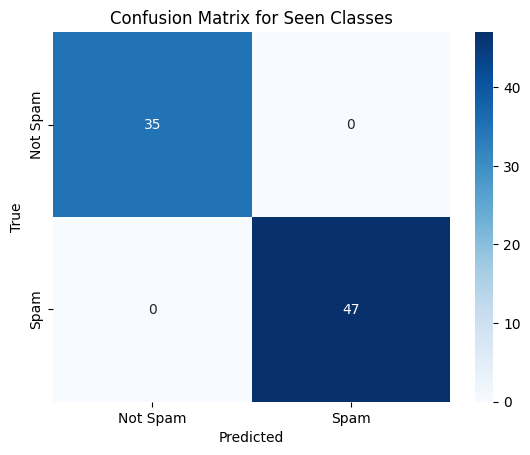

Unseen Class - Accuracy: 1.0000
Unseen Class - Precision: 1.0000
Unseen Class - Recall: 1.0000
Unseen Class - F1-Score: 1.0000

Classification Report for Unseen Classes:
              precision    recall  f1-score   support

    Not Spam       1.00      1.00      1.00       105
        Spam       1.00      1.00      1.00         1

    accuracy                           1.00       106
   macro avg       1.00      1.00      1.00       106
weighted avg       1.00      1.00      1.00       106



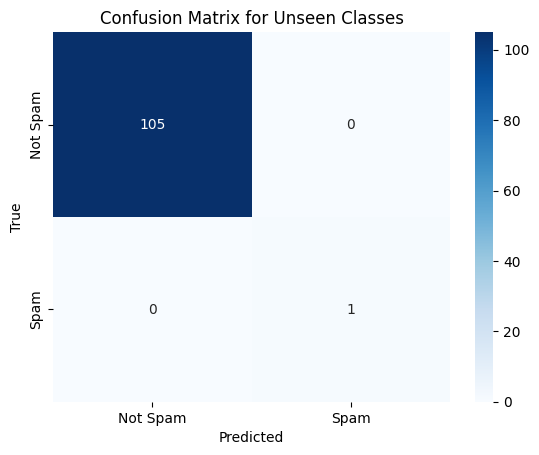

In [27]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, classification_report, confusion_matrix)

# Evaluate the model on seen classes
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient computation
    # Perform inference on the seen classes test data
    outputs_seen = model(X_test_tensor)
    _, predicted_seen = torch.max(outputs_seen, 1)  # Get the predicted class labels
    y_pred_seen = predicted_seen.numpy()  # Convert predictions to NumPy array

    # Calculate evaluation metrics for seen classes
    accuracy_seen = accuracy_score(y_test_tensor.numpy(), y_pred_seen)
    precision_seen = precision_score(y_test_tensor.numpy(), y_pred_seen, average='weighted')
    recall_seen = recall_score(y_test_tensor.numpy(), y_pred_seen, average='weighted')
    f1_seen = f1_score(y_test_tensor.numpy(), y_pred_seen, average='weighted')

    # Print evaluation metrics for seen classes
    print(f"Seen Class - Accuracy: {accuracy_seen:.4f}")
    print(f"Seen Class - Precision: {precision_seen:.4f}")
    print(f"Seen Class - Recall: {recall_seen:.4f}")
    print(f"Seen Class - F1-Score: {f1_seen:.4f}")

    # Classification Report for Seen Classes
    print("\nClassification Report for Seen Classes:")
    print(classification_report(y_test_tensor.numpy(), y_pred_seen, target_names=['Not Spam', 'Spam']))

    # Confusion Matrix for Seen Classes
    conf_matrix_seen = confusion_matrix(y_test_tensor.numpy(), y_pred_seen)
    sns.heatmap(conf_matrix_seen, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Spam', 'Spam'], yticklabels=['Not Spam', 'Spam'])
    plt.title('Confusion Matrix for Seen Classes')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Evaluate the model on unseen classes
    outputs_unseen = model(X_test_unseen_tensor)
    _, predicted_unseen = torch.max(outputs_unseen, 1)  # Get the predicted class labels
    y_pred_unseen = predicted_unseen.numpy()  # Convert predictions to NumPy array

    # Calculate evaluation metrics for unseen classes
    accuracy_unseen = accuracy_score(y_test_unseen_tensor.numpy(), y_pred_unseen)
    precision_unseen = precision_score(y_test_unseen_tensor.numpy(), y_pred_unseen, average='weighted')
    recall_unseen = recall_score(y_test_unseen_tensor.numpy(), y_pred_unseen, average='weighted')
    f1_unseen = f1_score(y_test_unseen_tensor.numpy(), y_pred_unseen, average='weighted')

    # Print evaluation metrics for unseen classes
    print(f"Unseen Class - Accuracy: {accuracy_unseen:.4f}")
    print(f"Unseen Class - Precision: {precision_unseen:.4f}")
    print(f"Unseen Class - Recall: {recall_unseen:.4f}")
    print(f"Unseen Class - F1-Score: {f1_unseen:.4f}")

    # Determine unique classes in the test set and predictions
    unique_classes = np.unique(np.concatenate((y_test_unseen_tensor.numpy(), y_pred_unseen)))
    
    # Dynamically set target names based on unique classes present
    target_names = ['Not Spam' if i == 0 else 'Spam' for i in unique_classes]
    
    # Classification Report for Unseen Classes
    print("\nClassification Report for Unseen Classes:")
    print(classification_report(y_test_unseen_tensor.numpy(), y_pred_unseen, target_names=target_names))

    # Confusion Matrix for Unseen Classes
    conf_matrix_unseen = confusion_matrix(y_test_unseen_tensor.numpy(), y_pred_unseen)
    sns.heatmap(conf_matrix_unseen, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.title('Confusion Matrix for Unseen Classes')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


Considerations

1.Unseen Class Definition:
Definition: Classes of spam messages not included in the training data.
Simulation: Generate or collect new spam examples not present in the training set.

2.Data Splitting:
Splits: Use random or stratified splits for training, validation, and testing.
Validation: Use a separate validation set for hyperparameter tuning.
Computational Resources:

3.Hardware: 
        Windows 10 64-bit 
        16 GB of RAM
        Ryzen 9 5900HS by AMD x64 processor with 3.30 GHz Radeon Graphics, 
        NVIDIA GeForce RTX 3050 Ti with 4 GB of GPU memory.



Expected Outcomes

1.ZSL Model:
Functionality: Accurately classify both seen and unseen spam messages.
ZSL Methods: Explain the chosen ZSL approach and its effectiveness.

2.Performance Analysis:
Evaluation: Compare performance on seen vs. unseen classes and analyze discrepancies.

3.Hyperparameter Tuning:
Process: Document the tuning process and results, including the best parameters and their impact on performance.

In [29]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader, TensorDataset, random_split
# import numpy as np
# from sklearn.metrics import accuracy_score

# # Define the neural network (as per your previous code)
# class ZSLNetwork(nn.Module):
#     def __init__(self, input_dim, hidden_dim, output_dim):
#         super(ZSLNetwork, self).__init__()
#         self.fc1 = nn.Linear(input_dim, hidden_dim)  # First fully connected layer
#         self.fc2 = nn.Linear(hidden_dim, output_dim)  # Second fully connected layer
#         self.relu = nn.ReLU()  # ReLU activation function
#         self.softmax = nn.Softmax(dim=1)  # Softmax for output layer

#     def forward(self, x):
#         x = self.relu(self.fc1(x))  # Apply ReLU after first layer
#         x = self.fc2(x)  # Second layer
#         return self.softmax(x)  # Apply softmax to get probabilities

# # Prepare the dataset
# input_dim = X_train_tensor.shape[1]  # Number of input features
# output_dim = len(np.unique(y_train_seen))  # Number of output classes

# # Create TensorDataset
# dataset = TensorDataset(X_train_tensor, y_train_tensor)

# # Split the dataset into training and validation sets
# train_size = int(0.8 * len(dataset))
# val_size = len(dataset) - train_size
# train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# # Create DataLoaders
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# # Hyperparameter tuning
# hidden_dims = [64, 128, 256]  # Different sizes for the hidden layer
# learning_rates = [0.001, 0.01, 0.1]  # Different learning rates
# num_epochs = 10  # Number of training epochs

# best_accuracy = 0
# best_params = {'hidden_dim': None, 'learning_rate': None}

# # Iterate over all combinations of hyperparameters
# for hidden_dim in hidden_dims:
#     for learning_rate in learning_rates:
#         print(f"Training with hidden_dim={hidden_dim} and learning_rate={learning_rate}")
        
#         # Initialize the model with the current hyperparameters
#         model = ZSLNetwork(input_dim, hidden_dim, output_dim)
#         criterion = nn.CrossEntropyLoss()
#         optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        
#         # Training loop
#         for epoch in range(num_epochs):
#             model.train()  # Set model to training mode
#             for inputs, labels in train_loader:
#                 optimizer.zero_grad()  # Zero the gradients
#                 outputs = model(inputs)  # Forward pass
#                 loss = criterion(outputs, labels)  # Compute loss
#                 loss.backward()  # Backpropagate
#                 optimizer.step()  # Update parameters
        
#         # Evaluate the model on the validation set
#         model.eval()  # Set model to evaluation mode
#         with torch.no_grad():
#             all_preds = []
#             all_labels = []
#             for inputs, labels in val_loader:
#                 outputs = model(inputs)  # Perform inference on the validation data
#                 _, predicted = torch.max(outputs, 1)  # Get predicted labels
#                 all_preds.extend(predicted.numpy())
#                 all_labels.extend(labels.numpy())
            
#             # Calculate accuracy
#             accuracy = accuracy_score(np.array(all_labels), np.array(all_preds))
        
#         # Print accuracy for the current hyperparameters
#         print(f"Accuracy with hidden_dim={hidden_dim} and learning_rate={learning_rate}: {accuracy:.4f}")
        
#         # Update best parameters if current accuracy is better
#         if accuracy > best_accuracy:
#             best_accuracy = accuracy
#             best_params['hidden_dim'] = hidden_dim
#             best_params['learning_rate'] = learning_rate

# # Print the best hyperparameters and corresponding accuracy
# print(f"Best Accuracy: {best_accuracy:.4f}")
# print(f"Best Hyperparameters: {best_params}")
